In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Creating a grid

In [3]:
from diffsims.generators.rotation_list_generators import get_beam_directions_grid

grid = get_beam_directions_grid("cubic",5, mesh="spherified_cube_corner")

/Users/nielscautaerts/Documents/PythonProjects/FORKS/diffsims/diffsims/generators/sphere_mesh_generators.py:507: RuntimeWarning: invalid value encountered in true_divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


<IPython.core.display.Javascript object>


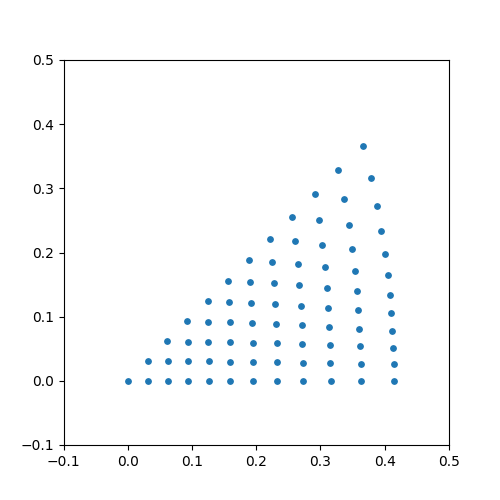

(-0.1, 0.5)

In [6]:
from orix.quaternion.rotation import Rotation
from orix.vector.vector3d import Vector3d
from orix.plot.stereo_plot import StereoPlot

rotations_regular =  Rotation.from_euler(np.deg2rad(grid))
rot_reg_test = rotations_regular*Vector3d.zvector()

fig, ax1 = plt.subplots(1, figsize=(5, 5), subplot_kw={"projection": "stereographic"})
ax1.scatter(rot_reg_test, s = 15)
ax1.set_xlim(-0.1, 0.5)
ax1.set_ylim(-0.1, 0.5)

# Creating a library

In [11]:
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator
import hyperspy.api as hs

In [8]:
import diffpy
structure_aus = diffpy.structure.loadStructure("Data/austeniteLP.cif")

In [13]:
# diffraction generator controls how the patterns will be simulated
diff_gen = DiffractionGenerator(accelerating_voltage=200, shape_factor_model="lorentzian")

experimental_data = hs.load("data/subset_data.hspy")
experimental_data.axes_manager

<Axes manager, axes: (2, 2|256, 256)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |      2 |      0 |   2e+02 |       2 |     nm 
               y |      2 |      0 |   2e+02 |       2 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
              kx |    256 |        |    -1.6 |   0.013 | $A^{-1}$ 
              ky |    256 |        |    -1.6 |   0.013 | $A^{-1}$

In [14]:
# experimental values necessary to scale the simulations
half_width_image = experimental_data.axes_manager["kx"].size//2
diffraction_scale = experimental_data.axes_manager["kx"].scale
reciprocal_radius = np.sqrt(2)*half_width_image*diffraction_scale

In [15]:
# list of phase names, list of structures, list of orientation grids to simulate
library_phases = StructureLibrary(["austenite"], [structure_aus], [grid])
lib_gen = DiffractionLibraryGenerator(diff_gen)
diff_lib = lib_gen.get_diffraction_library(library_phases,
                                           calibration=diffraction_scale,
                                           reciprocal_radius=reciprocal_radius,
                                           half_shape=(half_width_image, half_width_image),
                                           with_direct_beam=False,
                                           max_excitation_error=0.6e-1)

# Indexing the result

In [16]:
from pyxem.utils import indexation_utils as indx

In [17]:
help(indx.index_dataset_with_template_rotation)

Help on function index_dataset_with_template_rotation in module pyxem.utils.indexation_utils:

index_dataset_with_template_rotation(signal, library, phases=None, n_best=1, n_keep=100, frac_keep=None, delta_r=1.0, delta_theta=1.0, max_r=None, intensity_transform_function=None, find_direct_beam=False, direct_beam_positions=None, normalize_images=True, normalize_templates=True, parallelize_polar_conversion=False, chunks='auto', parallel_workers='auto')
    Index a dataset with template_matching while simultaneously optimizing in-plane rotation angle of the templates
    
    Parameters
    ----------
    signal : hyperspy.signals.Signal2D
        The 4D-STEM dataset
    library : diffsims.libraries.diffraction_library.DiffractionLibrary
        The library of simulated diffraction patterns
    phases : list, optional
        Names of phases in the library to do an indexation for. By default this is
        all phases in the library.
    n_best : int, optional
        Number of best soluti

In [47]:
results = indx.index_dataset_with_template_rotation(experimental_data,
                                                    diff_lib,
                                                    phases=None,
                                                    n_best=4,
                                                    n_keep=10,
                                                    frac_keep=None,
                                                    delta_r=1.0,
                                                    delta_theta=1.0,
                                                    max_r=115,
                                                    intensity_transform_function=np.sqrt,
                                                    find_direct_beam=False,
                                                    direct_beam_positions=None,
                                                    normalize_images=True,
                                                    normalize_templates=True,
                                                    parallelize_polar_conversion=False,
                                                    chunks='auto',
                                                    parallel_workers='auto')

[########################################] | 100% Completed |  0.1s


In [48]:
from pyxem.utils.plotting_utils import plot_template_over_pattern

In [49]:
results

{'austenite': {'template_index': array([[[68, 67, 66, 29],
          [67, 68, 66, 29]],
  
         [[68, 67, 66, 29],
          [68, 67, 66, 29]]], dtype=uint64),
  'orientation': array([[[[181.        ,  45.2188131 ,  82.92743293],
           [179.        ,  45.05418855,  86.47703534],
           [356.        ,  45.        ,  90.        ],
           [  4.        ,  40.18827429,  81.55392925]],
  
          [[179.        ,  45.05418855,  86.47703534],
           [181.        ,  45.2188131 ,  82.92743293],
           [356.        ,  45.        ,  90.        ],
           [  4.        ,  40.18827429,  81.55392925]]],
  
  
         [[[181.        ,  45.2188131 ,  82.92743293],
           [179.        ,  45.05418855,  86.47703534],
           [356.        ,  45.        ,  90.        ],
           [  4.        ,  40.18827429,  81.55392925]],
  
          [[181.        ,  45.2188131 ,  82.92743293],
           [179.        ,  45.05418855,  86.47703534],
           [356.        ,  45.     

# Checking the result

<IPython.core.display.Javascript object>


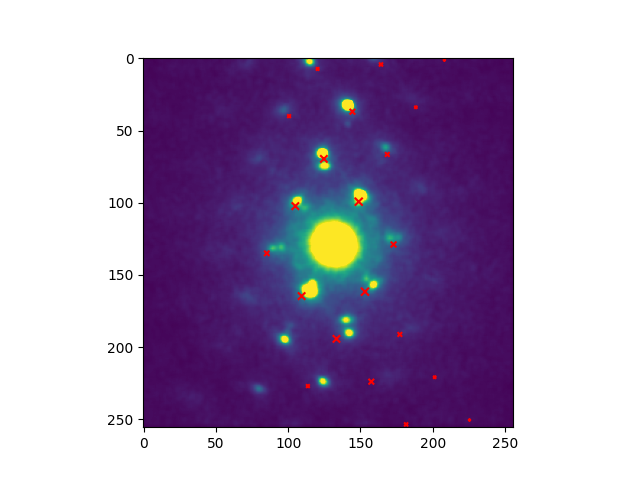

(<AxesSubplot:>,
 <matplotlib.collections.PathCollection at 0x14ca94e80>)

In [35]:
x, y = 0, 0
pattern = experimental_data.data[x,y]
index = results["austenite"]['template_index'][x,y][0]
in_plane_angle = results["austenite"]["orientation"][x,y][0][0]
simulation = diff_lib["austenite"]["simulations"][index]
plot_template_over_pattern(experimental_data.data[0,0],
                           simulation,
                           in_plane_angle=in_plane_angle,
                           find_direct_beam = True,
                           vmax=1000)

In [75]:
from orix.crystal_map.crystal_map import CrystalMap

for j, (k, v) in enumerate(results.items()):
    orientations = v["orientation"]
    indexes = v["template_index"]
    match = v["correlation"]
    n_best = orientations.shape[2]
    x = np.arange(0, experimental_data.data.shape[1])
    y = np.arange(0, experimental_data.data.shape[0])
    X, Y = np.meshgrid(x, y)
    scale = experimental_data.axes_manager[0].scale
    unit = experimental_data.axes_manager[1].units
    x = X.ravel()*experimental_data.axes_manager[0].scale
    y = Y.ravel()*experimental_data.axes_manager[1].scale
    orientations = Rotation.from_euler(np.deg2rad(orientations.reshape(y.shape[0], n_best, 3)))
    indexes = indexes.reshape(y.shape[0], n_best)
    match = indexes.reshape(y.shape[0], n_best)
    props = {"template_index": indexes, "correlation_index": match}
    crmap = CrystalMap(orientations,
                       x = x,
                       y = y,
                       prop = props,
                       scan_unit = unit,
                      )


(2, 2, 4, 3)
(2, 2, 4)
(2, 2, 4)
[0. 2. 0. 2.]
[0. 0. 2. 2.]


In [73]:
crmap

Phase  Orientations  Name  Space group  Point group  Proper point group     Color
    0    4 (100.0%)  None         None         None                None  tab:blue
Properties: template_index, correlation_index
Scan unit: nm